# 1. Download the Dataset

In [1]:
# Imports

# === Standard Library ===
import os
import sys
import stat
import time
import glob
import gc
import shutil
import pickle
import traceback
import warnings
from collections import Counter

# === Third-Party Libraries ===

# Data Handling and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_curve,
    roc_curve,
    auc
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Joblib
import joblib

# RAPIDS cuML
import cudf
import cupy as cp
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.preprocessing import LabelEncoder as cuLabelEncoder
from cuml.model_selection import train_test_split as cu_train_test_split
from cuml.decomposition import PCA as cuPCA

# Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi


In [2]:
# ─── Configuration ─────────────────────────────────────────────────────────────

# Path to the Kaggle API token file
KAGGLE_JSON_RELATIVE = "./kaggle.json"

# The Kaggle dataset identifier
DATASET_ID = "chethuhn/network-intrusion-dataset"

# Working directory (where you'll run this script)
WORK_DIR = os.getcwd()

# Where to download & unzip the dataset
EXTRACT_DIR = os.path.join(WORK_DIR, "CIC-IDS2017")


# ─── Functions ─────────────────────────────────────────────────────────────────

def setup_kaggle_credentials(kaggle_json_path: str):
    """Ensure kaggle.json exists, fix its permissions, and copy it to ~/.config/kaggle."""
    print("--- Setting up Kaggle API credentials ---")
    if not os.path.isfile(kaggle_json_path):
        sys.exit(
            f"Error: kaggle.json not found at {kaggle_json_path}.\n"
            "Download your token from https://www.kaggle.com/me/account"
        )

    # Restrict permissions to owner (required by Kaggle CLI)
    os.chmod(kaggle_json_path, stat.S_IRUSR | stat.S_IWUSR)

    # Copy into the directory KaggleApi expects:
    home = os.path.expanduser("~")
    config_dir = os.path.join(home, ".config", "kaggle")
    os.makedirs(config_dir, exist_ok=True)
    dest_path = os.path.join(config_dir, "kaggle.json")
    shutil.copy(kaggle_json_path, dest_path)
    os.chmod(dest_path, stat.S_IRUSR | stat.S_IWUSR)

    print(f"Copied credentials to {dest_path}")


def download_and_extract(api: KaggleApi):
    """Download & unzip the dataset if not already present."""
    need_download = (
        not os.path.isdir(EXTRACT_DIR)
        or not any(f.endswith(".csv") for f in os.listdir(EXTRACT_DIR))
    )

    if need_download:
        print(f"\n--- Downloading & extracting '{DATASET_ID}' to '{EXTRACT_DIR}' ---")
        api.dataset_download_files(
            DATASET_ID,
            path=EXTRACT_DIR,
            unzip=True,
            quiet=False
        )
        print("Download & extraction complete.")
    else:
        print(f"\nDataset already present in '{EXTRACT_DIR}', skipping download.")


def final_check():
    """Verify that CSV files are present in EXTRACT_DIR."""
    if not os.path.isdir(EXTRACT_DIR):
        sys.exit(f"Error: Extraction directory '{EXTRACT_DIR}' does not exist.")
    csv_files = [f for f in os.listdir(EXTRACT_DIR) if f.endswith(".csv")]
    if not csv_files:
        sys.exit(f"Error: No CSV files found in '{EXTRACT_DIR}'.")
    print(f"\nFound {len(csv_files)} CSV files in '{EXTRACT_DIR}':")
    for fn in csv_files:
        print("  -", fn)
    print("\n--- Dataset is ready for RAPIDS (cudf) ingestion! ---")


def main():
    # Expand user paths
    kaggle_json = os.path.expanduser(KAGGLE_JSON_RELATIVE)

    # 1) Validate and install credentials
    setup_kaggle_credentials(kaggle_json)

    # 2) Authenticate
    api = KaggleApi()
    api.authenticate()

    # 3) Download & extract
    download_and_extract(api)

    # 4) Final sanity check
    final_check()


if __name__ == "__main__":
    main()


--- Setting up Kaggle API credentials ---
Copied credentials to /home/mpdscamp/.config/kaggle/kaggle.json

Dataset already present in '/home/mpdscamp/pfc/CIC-IDS2017', skipping download.

Found 8 CSV files in '/home/mpdscamp/pfc/CIC-IDS2017':
  - Monday-WorkingHours.pcap_ISCX.csv
  - Tuesday-WorkingHours.pcap_ISCX.csv
  - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  - Wednesday-workingHours.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  - Friday-WorkingHours-Morning.pcap_ISCX.csv

--- Dataset is ready for RAPIDS (cudf) ingestion! ---


# 2. Pre-processing

## 2.1. Setup and Configuration

In [3]:
print("\n--- 1. Setup, Imports and Configuration ---")

# ─── CUDA memory pool ─────────────────────────────────────────────────────────
try:
    cp.cuda.set_allocator(cp.cuda.MemoryPool().malloc)
    print("CuPy CUDA MemoryPool allocator set.")
except AttributeError:
    print("CuPy MemoryPool allocator not available in this version/setup. Using default.")
print("RAPIDS libraries imported successfully — using GPU acceleration")

# ─── Silence warnings ─────────────────────────────────────────────────────────
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# ─── Setup results folder ─────────────────────────────────────────────────────
WORK_DIR = os.getcwd()
RESULTS_SAVE_DIR = os.path.join(WORK_DIR, "results")
os.makedirs(RESULTS_SAVE_DIR, exist_ok=True)
print(f"Results will be saved in: {RESULTS_SAVE_DIR}")

EXTRACT_DIR = os.path.join(WORK_DIR, "CIC-IDS2017")
if not os.path.exists(EXTRACT_DIR):
    print(f"Warning: EXTRACT_DIR '{EXTRACT_DIR}' does not exist. Please create it and add CSV files, or update the path.")

print("Setup complete.")


--- 1. Setup, Imports and Configuration ---
CuPy CUDA MemoryPool allocator set.
RAPIDS libraries imported successfully — using GPU acceleration
Results will be saved in: /home/mpdscamp/pfc/results
Setup complete.


## 2.2. Helper Functions

In [4]:
print("\n--- 2. Helper Functions ---")

use_binary_classification = True

def group_attack_labels(label, binary=None):
    # Determine whether to use binary classification
    use_binary = binary if binary is not None else use_binary_classification
    
    label = str(label).lower().strip()
    
    # Binary classification (just Benign or Malign)
    if use_binary:
        if label in ('benign', 'normal', 'legitimate'):
            return 'Benign'
        else:
            return 'Malign'
    
    # Detailed classification (original behavior)
    if any(a in label for a in ['dos','ddos','slowloris','slowhttptest','hulk','goldeneye']):
        return 'DoS_Attack'
    if any(a in label for a in ['bruteforce','brute force','ftp-patator','ssh-patator']):
        return 'Brute_Force_Attack'
    if any(a in label for a in ['web','sql','xss','injection']):
        return 'Web_Attack'
    if any(a in label for a in ['port','scan','nmap','portsweep','infiltration']):
        return 'Port_Scan_Infiltration'
    if 'bot' in label:
        return 'Botnet'
    if label in ('benign','normal','legitimate'):
        return 'Benign'
    return None

def plot_class_distribution(y_data, plot_title, filename_to_save=None):
    if isinstance(y_data, cudf.Series):
        counts = y_data.value_counts().to_pandas()
    elif isinstance(y_data, pd.Series):
        counts = y_data.value_counts()
    else: # Fallback for CuPy array or other types
        counts = pd.Series(y_data).value_counts()

    if counts.empty:
        print(f"Cannot plot distribution for '{plot_title}': No data.")
        return

    plt.figure(figsize=(max(10, len(counts) * 0.8), 6)) # Adjust width based on number of classes
    ax = sns.barplot(x=counts.index, y=counts.values, palette="viridis")
    max_val = counts.values.max() if len(counts.values) > 0 else 1
    for i, v in enumerate(counts.values):
        ax.text(i, v + 0.01 * max_val, f"{v}", ha='center', fontweight='medium')
    plt.title(plot_title, fontsize=15); plt.xlabel('Class', fontsize=12); plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10); plt.yticks(fontsize=10)
    plt.tight_layout()
    if filename_to_save:
        plt.savefig(filename_to_save); print(f"Saved plot: {filename_to_save}")
    plt.show()
    plt.close()

print("Helper functions defined.")


--- 2. Helper Functions ---
Helper functions defined.


## 2.3. Loading and Concatenating Data

In [5]:
print("\n--- 3. Loading and Concatenating Data ---")

start_load_time = time.time()

if not os.path.isdir(EXTRACT_DIR):
    raise FileNotFoundError(f"Dataset directory not found: {EXTRACT_DIR}. Please set EXTRACT_DIR correctly in Cell 1.")

all_files = glob.glob(os.path.join(EXTRACT_DIR, "*.csv"))
if not all_files:
    raise FileNotFoundError(f"No CSVs found in: {EXTRACT_DIR}. Please ensure CSV files are present.")

print(f"Found {len(all_files)} files in '{EXTRACT_DIR}':")
for f_path in all_files:
    print("  ", os.path.basename(f_path))

parts, total_rows = [], 0
for path in all_files:
    file_name = os.path.basename(path)
    print(f"→ Loading {file_name} with cuDF…")
    try:
        df_part = cudf.read_csv(path)
        df_part.columns = [c.strip().replace(' ', '_') for c in df_part.columns] # Standardize column names
    except Exception as e:
        print(f"  cuDF failed for {file_name}: {e} → Falling back to pandas…")
        try:
            tmp = pd.read_csv(path, low_memory=False, on_bad_lines='warn') # Warn on bad lines
            tmp.columns = [c.strip().replace(' ', '_') for c in tmp.columns] # Standardize column names
            df_part = cudf.DataFrame.from_pandas(tmp)
            del tmp
        except Exception as pd_e:
            print(f"  Pandas also failed for {file_name}: {pd_e}. Skipping this file.")
            continue # Skip to next file
    parts.append(df_part)
    total_rows += len(df_part)
    print(f"  Loaded {file_name}: {len(df_part):,} rows (cumulative {total_rows:,})")
    gc.collect()

if not parts:
    raise ValueError("No data loaded. 'parts' list is empty. Check CSV files and loading process.")

df_raw = cudf.concat(parts, ignore_index=True)
del parts; gc.collect()
print(f"Data concatenated in {time.time() - start_load_time:.1f}s — Raw Shape: {df_raw.shape}")
print(f"Raw data columns: {df_raw.columns.to_list()}")


--- 3. Loading and Concatenating Data ---
Found 8 files in '/home/mpdscamp/pfc/CIC-IDS2017':
   Monday-WorkingHours.pcap_ISCX.csv
   Tuesday-WorkingHours.pcap_ISCX.csv
   Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
   Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
   Wednesday-workingHours.pcap_ISCX.csv
   Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
   Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
   Friday-WorkingHours-Morning.pcap_ISCX.csv
→ Loading Monday-WorkingHours.pcap_ISCX.csv with cuDF…
  Loaded Monday-WorkingHours.pcap_ISCX.csv: 529,918 rows (cumulative 529,918)
→ Loading Tuesday-WorkingHours.pcap_ISCX.csv with cuDF…
  Loaded Tuesday-WorkingHours.pcap_ISCX.csv: 445,909 rows (cumulative 975,827)
→ Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv with cuDF…
  Loaded Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv: 288,602 rows (cumulative 1,264,429)
→ Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.c

## 2.4. Label Grouping and Initial Visualization


--- 4. Grouping Attack Labels ---
Using 'Label' as the label column.
Saved plot: /home/mpdscamp/pfc/results/label_distributions/dist_original_labels.png


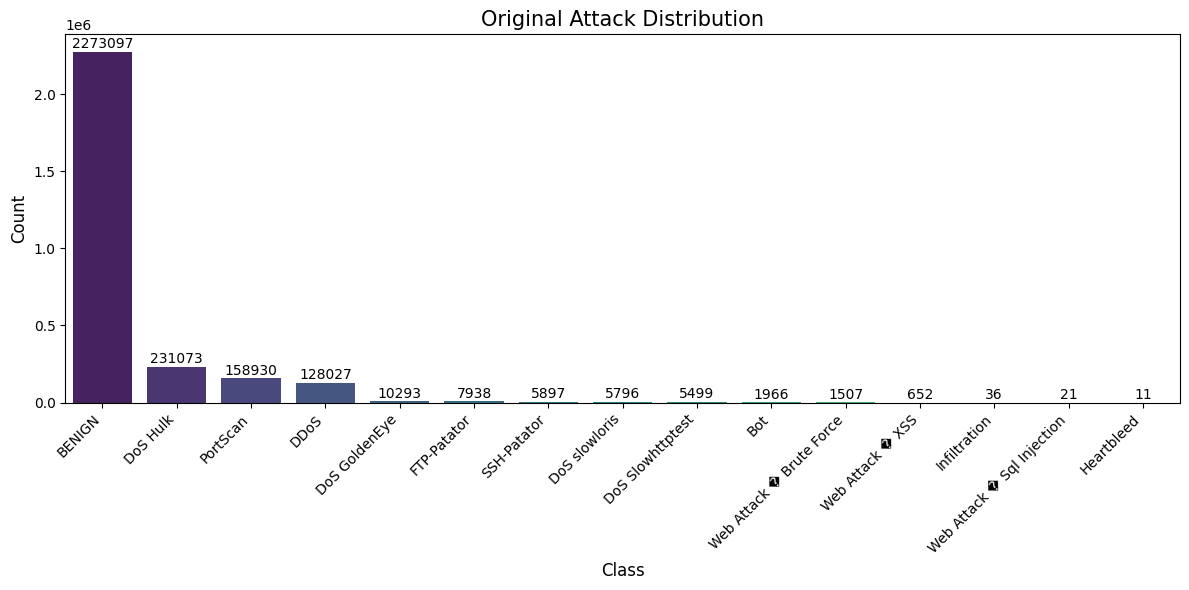

Saved plot: /home/mpdscamp/pfc/results/label_distributions/dist_grouped_labels.png


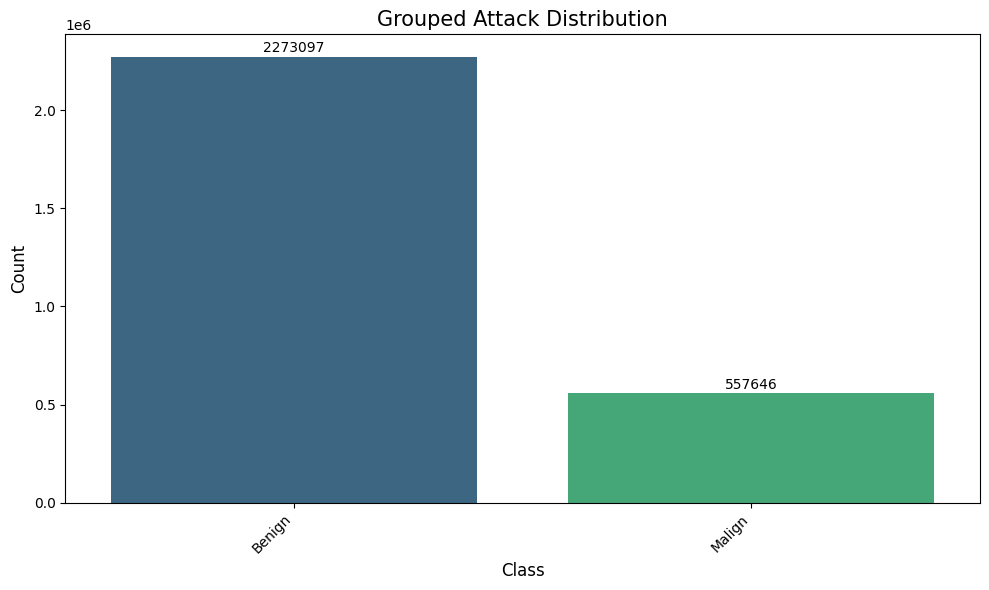

Unique labels after grouping: ['Benign', 'Malign']


In [6]:
print("\n--- 4. Grouping Attack Labels ---")

# Identify label column
label_col_candidates = [c for c in df_raw.columns if 'label' in c.lower() or 'attack' in c.lower()]
if not label_col_candidates:
    if 'Label' in df_raw.columns: label_col = 'Label'
    elif 'Attack_Type' in df_raw.columns: label_col = 'Attack_Type'
    elif 'Class' in df_raw.columns: label_col = 'Class'
    else:
        label_col = df_raw.columns[-1]
        print(f"Warning: Could not confidently determine label column. Using last column: '{label_col}'")
else:
    label_col = label_col_candidates[0]
print(f"Using '{label_col}' as the label column.")

# Save original length to report removed records
original_length = len(df_raw)
df_raw['original_label'] = df_raw[label_col].copy()

try:
    # Apply the grouping function
    labels_to_group_pd = df_raw[label_col].astype(str).to_pandas()
    grouped_labels_pd = labels_to_group_pd.apply(group_attack_labels)
    
    # Identify unrecognized labels
    unrecognized_mask_pd = grouped_labels_pd.isnull()
    unrecognized_count = unrecognized_mask_pd.sum()
    
    if unrecognized_count > 0:
        # Remove unrecognized labels
        print(f"Removing {unrecognized_count} records with unrecognized attack labels ({unrecognized_count/len(df_raw)*100:.2f}%)")
        
        # Apply the mask to keep only rows with recognized labels
        if isinstance(df_raw, cudf.DataFrame):
            valid_mask = cudf.Series(~unrecognized_mask_pd.values)
            df_raw = df_raw.loc[valid_mask]
            df_raw[label_col] = cudf.Series(grouped_labels_pd[~unrecognized_mask_pd].values)
        else:
            df_raw = df_raw.loc[~unrecognized_mask_pd]
            df_raw[label_col] = grouped_labels_pd[~unrecognized_mask_pd].values
    else:
        # Update the label column with grouped labels
        if isinstance(df_raw, cudf.DataFrame):
            df_raw[label_col] = cudf.Series(grouped_labels_pd.values)
        else:
            df_raw[label_col] = grouped_labels_pd.values
    
    # Cleanup
    del labels_to_group_pd, grouped_labels_pd, unrecognized_mask_pd
    if 'valid_mask' in locals():
        del valid_mask
        
except Exception as e:
    print(f"Error during label grouping: {e}")
    traceback.print_exc()

gc.collect()

# Create subfolder for label distribution results
labels_subdir = os.path.join(RESULTS_SAVE_DIR, "label_distributions")
os.makedirs(labels_subdir, exist_ok=True)

# Plot label distributions
try:
    plot_class_distribution(
        df_raw['original_label'],
        "Original Attack Distribution",
        os.path.join(labels_subdir, "dist_original_labels.png")
    )
    plot_class_distribution(
        df_raw[label_col],
        "Grouped Attack Distribution",
        os.path.join(labels_subdir, "dist_grouped_labels.png")
    )

except Exception as e:
    print(f"Could not plot attack distributions: {e}")

print(f"Unique labels after grouping: {df_raw[label_col].unique().to_pandas().tolist()}")

## 2.5. Splitting the Dataset

In [7]:
print("\n--- 2.5 Dataset Splitting ---")

# Check if splits already exist
splits_dir = os.path.join(RESULTS_SAVE_DIR, "splits")
try:
    if (os.path.exists(os.path.join(splits_dir, "train.parquet")) and 
        os.path.exists(os.path.join(splits_dir, "val.parquet")) and 
        os.path.exists(os.path.join(splits_dir, "test.parquet"))):
        print("Loading existing splits from disk...")
        df_train = pd.read_parquet(os.path.join(splits_dir, "train.parquet"))
        df_val = pd.read_parquet(os.path.join(splits_dir, "val.parquet"))
        df_test = pd.read_parquet(os.path.join(splits_dir, "test.parquet"))
        
        # Convert to cuDF if original data was cuDF
        if 'cudf' in globals() and isinstance(df_raw, cudf.DataFrame):
            df_train = cudf.DataFrame.from_pandas(df_train)
            df_val = cudf.DataFrame.from_pandas(df_val)
            df_test = cudf.DataFrame.from_pandas(df_test)
        
        print(f"Loaded splits: train ({len(df_train)}), val ({len(df_val)}), test ({len(df_test)}) rows")
    else:
        raise FileNotFoundError("Split files not found")
        
except Exception as e:
    # Define split ratios
    TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.75, 0.10, 0.15
    print(f"Creating new splits: {TRAIN_RATIO:.0%} train, {VAL_RATIO:.0%} validation, {TEST_RATIO:.0%} test")

    # Remove None labels before stratification
    if isinstance(df_raw, cudf.DataFrame):
        valid_mask = ~df_raw[label_col].isnull()
        if valid_mask.sum() < len(df_raw):
            df_raw = df_raw.loc[valid_mask]
    else:
        valid_mask = df_raw[label_col].notnull()
        if valid_mask.sum() < len(df_raw):
            df_raw = df_raw.loc[valid_mask]

    # Prepare stratification values
    stratify_values = df_raw[label_col].to_pandas() if isinstance(df_raw, cudf.DataFrame) else df_raw[label_col]

    # Train/test split
    indices = np.arange(len(df_raw))
    train_val_idx, test_idx = train_test_split(indices, test_size=TEST_RATIO, random_state=42, stratify=stratify_values)

    # Train/validation split
    train_val_stratify = df_raw.iloc[train_val_idx][label_col].to_pandas() if isinstance(df_raw, cudf.DataFrame) else df_raw.iloc[train_val_idx][label_col]
    val_ratio_adjusted = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
    train_idx, val_idx = train_test_split(train_val_idx, test_size=val_ratio_adjusted, random_state=42, stratify=train_val_stratify)

    # Check available memory for optimization
    import psutil
    available_memory = psutil.virtual_memory().available / (1024 ** 3)
    required_memory_estimate = len(df_raw) * len(df_raw.columns) * 8 / (1024 ** 3) * 2

    # Create dataframes based on memory availability
    if available_memory > required_memory_estimate:
        df_train = df_raw.iloc[train_idx].copy()
        df_val = df_raw.iloc[val_idx].copy()
        df_test = df_raw.iloc[test_idx].copy()
    else:
        # Memory-efficient approach: process in batches
        batch_size = 500000
        
        # Initialize empty dataframes
        if isinstance(df_raw, cudf.DataFrame):
            df_train, df_val, df_test = cudf.DataFrame(), cudf.DataFrame(), cudf.DataFrame()
        else:
            df_train = pd.DataFrame(columns=df_raw.columns)
            df_val = pd.DataFrame(columns=df_raw.columns)
            df_test = pd.DataFrame(columns=df_raw.columns)
        
        # Create index sets for faster lookup
        train_idx_set, val_idx_set, test_idx_set = set(train_idx), set(val_idx), set(test_idx)
        
        # Process in batches
        for i in range(0, len(df_raw), batch_size):
            end_idx = min(i + batch_size, len(df_raw))
            batch_indices = list(range(i, end_idx))
            
            batch_train = [idx for idx in batch_indices if idx in train_idx_set]
            batch_val = [idx for idx in batch_indices if idx in val_idx_set]
            batch_test = [idx for idx in batch_indices if idx in test_idx_set]
            
            if batch_train: df_train = pd.concat([df_train, df_raw.iloc[batch_train]])
            if batch_val: df_val = pd.concat([df_val, df_raw.iloc[batch_val]])
            if batch_test: df_test = pd.concat([df_test, df_raw.iloc[batch_test]])
            
            gc.collect()

    # Print split sizes
    print(f"Split complete: Train ({len(df_train)}), Val ({len(df_val)}), Test ({len(df_test)}) samples")

    # Save splits to disk
    try:
        os.makedirs(splits_dir, exist_ok=True)
        
        for name, df in [("train", df_train), ("val", df_val), ("test", df_test)]:
            if isinstance(df, cudf.DataFrame):
                df.to_pandas().to_parquet(os.path.join(splits_dir, f"{name}.parquet"))
            else:
                df.to_parquet(os.path.join(splits_dir, f"{name}.parquet"))
        
        print(f"Splits saved to {splits_dir}")
    except Exception as e:
        print(f"Error saving splits: {e}")

# Free memory
gc.collect()


--- 2.5 Dataset Splitting ---
Creating new splits: 75% train, 10% validation, 15% test
Split complete: Train (2123056), Val (283075), Test (424612) samples
Splits saved to /home/mpdscamp/pfc/results/splits


349

## 2.6. Data Quality Processing

In [8]:
print("\n--- 2.6 Enhanced Data Quality Processing ---")
start_time = time.time()

# Check if cleaned splits already exist
cleaned_splits_dir = os.path.join(RESULTS_SAVE_DIR, "cleaned_splits")
try:
    if (os.path.exists(os.path.join(cleaned_splits_dir, "train_clean.parquet")) and 
        os.path.exists(os.path.join(cleaned_splits_dir, "val_clean.parquet")) and 
        os.path.exists(os.path.join(cleaned_splits_dir, "test_clean.parquet"))):
        
        # Load cleaned splits
        df_train = pd.read_parquet(os.path.join(cleaned_splits_dir, "train_clean.parquet"))
        df_val = pd.read_parquet(os.path.join(cleaned_splits_dir, "val_clean.parquet"))
        df_test = pd.read_parquet(os.path.join(cleaned_splits_dir, "test_clean.parquet"))
        
        # Convert to cuDF if necessary
        if 'cudf' in globals() and 'df_raw' in globals() and isinstance(df_raw, cudf.DataFrame):
            df_train = cudf.DataFrame.from_pandas(df_train)
            df_val = cudf.DataFrame.from_pandas(df_val)
            df_test = cudf.DataFrame.from_pandas(df_test)
        
        print(f"Loaded cleaned splits: train ({len(df_train)}), val ({len(df_val)}), test ({len(df_test)}) rows")
        cleaned_already = True
    else:
        cleaned_already = False
        
except Exception as e:
    cleaned_already = False

# Only continue with processing if needed
if not cleaned_already:
    # Load splits if not in memory
    try:
        splits_dir = os.path.join(RESULTS_SAVE_DIR, "splits")
        df_train = pd.read_parquet(os.path.join(splits_dir, "train.parquet"))
        df_val = pd.read_parquet(os.path.join(splits_dir, "val.parquet"))
        df_test = pd.read_parquet(os.path.join(splits_dir, "test.parquet"))
        
        # Convert to cuDF if necessary
        if 'cudf' in globals() and 'df_raw' in globals() and isinstance(df_raw, cudf.DataFrame):
            df_train = cudf.DataFrame.from_pandas(df_train)
            df_val = cudf.DataFrame.from_pandas(df_val)
            df_test = cudf.DataFrame.from_pandas(df_test)
    except Exception as e:
        print(f"Error loading splits: {e}")

    def handle_data_quality(df, label_column, max_time_per_column=60):
        """Optimized data quality handling for network traffic data"""
        feature_cols = [col for col in df.columns if col != label_column and col != 'original_label']
        is_cudf = isinstance(df, cudf.DataFrame)
        skipped_columns = []
        
        # Process columns in batches
        BATCH_SIZE = 5
        for batch_start in range(0, len(feature_cols), BATCH_SIZE):
            batch_end = min(batch_start + BATCH_SIZE, len(feature_cols))
            batch_cols = feature_cols[batch_start:batch_end]
            
            for col in batch_cols:
                col_start_time = time.time()
                
                try:
                    # 1. Replace infinities with NaN
                    if is_cudf:
                        try:
                            df[col] = df[col].astype('float64')
                            df[col] = df[col].replace([float('inf'), float('-inf')], float('nan'))
                        except Exception:
                            pass
                    else:
                        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
                    
                    # 2. Handle NaNs
                    if is_cudf:
                        if df[col].isna().any():
                            try:
                                median_val = df[col].dropna().median()
                                df[col] = df[col].fillna(median_val)
                            except:
                                df[col] = df[col].fillna(0.0)
                    else:
                        if df[col].isna().any():
                            median_val = df[col].median() if not df[col].isna().all() else 0
                            df[col] = df[col].fillna(median_val)
                    
                    # 3. Handle outliers - with timeout protection
                    if df.shape[0] < 5000000:  # Skip for very large datasets
                        outlier_start = time.time()
                        try:
                            if is_cudf:
                                p01 = df[col].quantile(0.01)
                                p99 = df[col].quantile(0.99)
                                
                                if time.time() - outlier_start > 30:
                                    skipped_columns.append(col)
                                else:
                                    df[col] = df[col].clip(p01, p99)
                            else:
                                p01 = df[col].quantile(0.01)
                                p99 = df[col].quantile(0.99)
                                df[col] = df[col].clip(p01, p99)
                        except:
                            skipped_columns.append(col)
                    
                    # Check if processing this column took too long
                    if time.time() - col_start_time > max_time_per_column:
                        skipped_columns.append(col)
                
                except Exception:
                    skipped_columns.append(col)
                
                gc.collect()
            
            gc.collect()
        
        if skipped_columns:
            print(f"Skipped {len(skipped_columns)} problematic columns")
            
        return df

    # Process datasets
    print("\nCleaning datasets...")
    df_train = handle_data_quality(df_train, label_col)
    df_val = handle_data_quality(df_val, label_col)
    df_test = handle_data_quality(df_test, label_col)

    # Save cleaned splits
    try:
        os.makedirs(cleaned_splits_dir, exist_ok=True)
        
        for name, df in [("train_clean", df_train), ("val_clean", df_val), ("test_clean", df_test)]:
            if isinstance(df, cudf.DataFrame):
                df.to_pandas().to_parquet(os.path.join(cleaned_splits_dir, f"{name}.parquet"), compression='snappy')
            else:
                df.to_parquet(os.path.join(cleaned_splits_dir, f"{name}.parquet"), compression='snappy')
        
        print(f"Cleaned datasets saved to {cleaned_splits_dir}")
    except Exception as e:
        print(f"Error saving cleaned splits: {e}")

    print(f"Data quality processing completed in {time.time() - start_time:.1f} seconds")

gc.collect()


--- 2.6 Enhanced Data Quality Processing ---

Cleaning datasets...
Cleaned datasets saved to /home/mpdscamp/pfc/results/cleaned_splits
Data quality processing completed in 96.1 seconds


0

# 3. Feature Selection

In [9]:
print("\n--- 3. Feature Selection with Visualizations ---")

# Create directories
viz_dir = os.path.join(RESULTS_SAVE_DIR, "visualizations")
selected_dir = os.path.join(RESULTS_SAVE_DIR, "selected_features")
os.makedirs(viz_dir, exist_ok=True)
os.makedirs(selected_dir, exist_ok=True)

# Check if selected features already exist
try:
    if os.path.exists(os.path.join(selected_dir, "train_selected.parquet")):
        # Load the selected feature datasets
        df_train_selected = pd.read_parquet(os.path.join(selected_dir, "train_selected.parquet"))
        df_val_selected = pd.read_parquet(os.path.join(selected_dir, "val_selected.parquet"))
        df_test_selected = pd.read_parquet(os.path.join(selected_dir, "test_selected.parquet"))
        
        # Convert to cuDF if needed
        if 'cudf' in globals():
            df_train_selected = cudf.DataFrame.from_pandas(df_train_selected)
            df_val_selected = cudf.DataFrame.from_pandas(df_val_selected)
            df_test_selected = cudf.DataFrame.from_pandas(df_test_selected)
        
        # Extract selected features
        selected_features = [col for col in df_train_selected.columns if col != label_col and col != 'original_label']
        print(f"Loaded existing selected feature datasets with {len(selected_features)} features")
        selection_already_done = True
    else:
        selection_already_done = False
except Exception:
    selection_already_done = False

# Only continue with feature selection if needed
if not selection_already_done:
    # Load cleaned datasets if needed
    try:
        cleaned_splits_dir = os.path.join(RESULTS_SAVE_DIR, "cleaned_splits")
        df_train = pd.read_parquet(os.path.join(cleaned_splits_dir, "train_clean.parquet"))
        df_val = pd.read_parquet(os.path.join(cleaned_splits_dir, "val_clean.parquet"))
        df_test = pd.read_parquet(os.path.join(cleaned_splits_dir, "test_clean.parquet"))
        
        # Convert to cuDF if needed
        if 'cudf' in globals():
            df_train = cudf.DataFrame.from_pandas(df_train)
            df_val = cudf.DataFrame.from_pandas(df_val)
            df_test = cudf.DataFrame.from_pandas(df_test)
    except Exception as e:
        print(f"Error loading cleaned datasets: {e}")

    # Separate features and target
    X_train = df_train.drop([label_col] + (['original_label'] if 'original_label' in df_train.columns else []), axis=1)
    y_train = df_train[label_col]
    initial_features = list(X_train.columns)
    print(f"Starting feature selection with {len(initial_features)} features")

    # 1. Remove low variance features
    var_threshold = 0.01
    selector = VarianceThreshold(threshold=var_threshold)

    # Apply variance threshold
    if isinstance(X_train, cudf.DataFrame):
        X_train_pd = X_train.to_pandas()
        X_var_selected = selector.fit_transform(X_train_pd)
        selected_features = X_train_pd.columns[selector.get_support()]
    else:
        X_var_selected = selector.fit_transform(X_train)
        selected_features = X_train.columns[selector.get_support()]
    
    X_train = X_train[selected_features]
    post_var_features = list(X_train.columns)
    print(f"After variance filtering: {len(post_var_features)} features")

    # 2. Remove highly correlated features
    if isinstance(X_train, cudf.DataFrame):
        corr_matrix = X_train.corr().to_pandas()
    else:
        corr_matrix = X_train.corr()

    # Plot correlation heatmap
    plt.figure(figsize=(16, 14))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, 
                square=True, linewidths=.5, annot=False, cbar_kws={"shrink": .5})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, "feature_correlation.png"))
    plt.close()

    # Remove highly correlated features
    high_corr_threshold = 0.95
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > high_corr_threshold)]
    X_train = X_train.drop(columns=to_drop)
    post_corr_features = list(X_train.columns)
    print(f"After correlation filtering: {len(post_corr_features)} features")

    # 3. Tree-based feature importance
    try:
        from cuml.ensemble import RandomForestClassifier as cuRF
        
        # Ensure data types are compatible with cuML
        if isinstance(X_train, cudf.DataFrame):
            for col in X_train.columns:
                X_train[col] = X_train[col].astype('float32')
            
            # Convert target to integer if categorical
            if y_train.dtype == 'object' or y_train.dtype.name == 'category':
                unique_labels = y_train.unique().to_pandas()
                label_map = {label: i for i, label in enumerate(unique_labels)}
                y_train_int = y_train.map(lambda x: label_map.get(x, 0)).astype('int32')
            else:
                y_train_int = y_train.astype('int32')
        else:
            X_train = X_train.astype('float32')
            if y_train.dtype == 'object' or y_train.dtype.name == 'category':
                unique_labels = y_train.unique()
                label_map = {label: i for i, label in enumerate(unique_labels)}
                y_train_int = y_train.map(lambda x: label_map.get(x, 0)).astype('int32')
            else:
                y_train_int = y_train.astype('int32')
        
        model = cuRF(n_estimators=100, max_depth=10, random_state=42)
        model.fit(X_train, y_train_int)
        importances = model.feature_importances_
        
    except Exception:
        # Fall back to sklearn
        from sklearn.ensemble import RandomForestClassifier as skRF
        
        if isinstance(X_train, cudf.DataFrame):
            X_train_pd = X_train.to_pandas()
            y_train_pd = y_train.to_pandas()
        else:
            X_train_pd = X_train
            y_train_pd = y_train
        
        model = skRF(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
        model.fit(X_train_pd, y_train_pd)
        importances = model.feature_importances_

    # Feature importance analysis
    features = list(X_train.columns)
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot top 20 feature importances
    plt.figure(figsize=(14, 10))
    top20 = feature_importance.head(20)
    ax = sns.barplot(x='Importance', y='Feature', data=top20)
    plt.title('Top 20 Features by Importance')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, "feature_importance_top20.png"))
    plt.close()

    # Calculate cumulative importance
    sorted_importance = feature_importance.sort_values('Importance', ascending=False)
    sorted_importance['Cumulative Importance'] = sorted_importance['Importance'].cumsum()

    # Use cumulative importance threshold (96%)
    cumulative_threshold = 0.96
    features_needed = sum(sorted_importance['Cumulative Importance'] <= cumulative_threshold) + 1
    selected_features = sorted_importance['Feature'].head(features_needed).tolist()
    
    # Plot cumulative importance
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(sorted_importance) + 1), sorted_importance['Cumulative Importance'], 'b-')
    plt.hlines(y=cumulative_threshold, xmin=1, xmax=len(sorted_importance), colors='r', linestyles='--', 
               label=f'{cumulative_threshold*100:.0f}% Importance Threshold')
    plt.vlines(x=features_needed, ymin=0, ymax=cumulative_threshold, colors='g', linestyles='--',
               label=f'{features_needed} Features Needed')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Feature Importance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, "cumulative_importance.png"))
    plt.close()

    # Apply feature selection to all datasets
    X_train_selected = X_train[selected_features]
    X_val_selected = df_val[selected_features] 
    X_test_selected = df_test[selected_features]

    # Feature selection summary visualization
    stages = ['Initial', 'After Variance', 'After Correlation', 'Final Selected']
    feature_counts = [len(initial_features), len(post_var_features), len(post_corr_features), len(selected_features)]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(stages, feature_counts, color=['blue', 'green', 'orange', 'red'])
    plt.title('Feature Selection Journey')
    plt.ylabel('Number of Features')
    plt.tight_layout()

    # Add count labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom')

    plt.savefig(os.path.join(viz_dir, "feature_selection_journey.png"))
    plt.close()

    print(f"Selected {len(selected_features)} features that capture {cumulative_threshold*100:.0f}% of importance")

    # Update datasets with selected features
    if isinstance(X_train, cudf.DataFrame):
        df_train_selected = cudf.concat([X_train_selected, df_train[[label_col]]], axis=1)
        df_val_selected = cudf.concat([X_val_selected, df_val[[label_col]]], axis=1)
        df_test_selected = cudf.concat([X_test_selected, df_test[[label_col]]], axis=1)
    else:
        df_train_selected = pd.concat([X_train_selected, df_train[[label_col]]], axis=1)
        df_val_selected = pd.concat([X_val_selected, df_val[[label_col]]], axis=1)
        df_test_selected = pd.concat([X_test_selected, df_test[[label_col]]], axis=1)

    # Save feature selection results
    try:
        feature_importance.to_csv(os.path.join(RESULTS_SAVE_DIR, "feature_importance.csv"), index=False)
        with open(os.path.join(RESULTS_SAVE_DIR, "selected_features.txt"), 'w') as f:
            f.write('\n'.join(selected_features))
        
        # Save the selected feature datasets
        for name, df in [("train_selected", df_train_selected), 
                         ("val_selected", df_val_selected), 
                         ("test_selected", df_test_selected)]:
            if isinstance(df, cudf.DataFrame):
                df.to_pandas().to_parquet(os.path.join(selected_dir, f"{name}.parquet"), compression='snappy')
            else:
                df.to_parquet(os.path.join(selected_dir, f"{name}.parquet"), compression='snappy')
    except Exception as e:
        print(f"Error saving results: {e}")

gc.collect()


--- 3. Feature Selection with Visualizations ---
Starting feature selection with 78 features
After variance filtering: 66 features
After correlation filtering: 42 features
Selected 29 features that capture 96% of importance


60

# 4. Data Scaling and Analysis

## 4.1. Data Scaling

In [10]:
print("\n--- 4. Data Scaling ---")

start_time = time.time()

# Create directories
viz_dir = os.path.join(RESULTS_SAVE_DIR, "visualizations")
scaled_dir = os.path.join(RESULTS_SAVE_DIR, "scaled_data")
os.makedirs(viz_dir, exist_ok=True)
os.makedirs(scaled_dir, exist_ok=True)

# Check if scaled data already exists
try:
    if os.path.exists(os.path.join(scaled_dir, "train_scaled.parquet")):
        train_scaled = pd.read_parquet(os.path.join(scaled_dir, "train_scaled.parquet"))
        val_scaled = pd.read_parquet(os.path.join(scaled_dir, "val_scaled.parquet"))
        test_scaled = pd.read_parquet(os.path.join(scaled_dir, "test_scaled.parquet"))
        print(f"Loaded existing scaled datasets: train ({train_scaled.shape[0]} rows), val ({val_scaled.shape[0]} rows), test ({test_scaled.shape[0]} rows)")
        scaling_already_done = True
    else:
        scaling_already_done = False
except Exception:
    scaling_already_done = False

# Only continue with scaling if needed
if not scaling_already_done:
    # Load selected feature datasets
    try:
        selected_dir = os.path.join(RESULTS_SAVE_DIR, "selected_features")
        df_train_selected = pd.read_parquet(os.path.join(selected_dir, "train_selected.parquet"))
        df_val_selected = pd.read_parquet(os.path.join(selected_dir, "val_selected.parquet"))
        df_test_selected = pd.read_parquet(os.path.join(selected_dir, "test_selected.parquet"))
        
        # Convert to cuDF if needed
        if 'cudf' in globals():
            df_train_selected = cudf.DataFrame.from_pandas(df_train_selected)
            df_val_selected = cudf.DataFrame.from_pandas(df_val_selected)
            df_test_selected = cudf.DataFrame.from_pandas(df_test_selected)
            
    except Exception as e:
        print(f"Error loading selected datasets: {e}")
        raise e
        
    # Separate features and labels
    X_train = df_train_selected.drop(columns=[label_col])
    y_train = df_train_selected[label_col]
    X_val = df_val_selected.drop(columns=[label_col])
    y_val = df_val_selected[label_col]
    X_test = df_test_selected.drop(columns=[label_col])
    y_test = df_test_selected[label_col]
    
    # Convert to pandas for scaling
    if isinstance(X_train, cudf.DataFrame):
        X_train_pd = X_train.to_pandas()
        X_val_pd = X_val.to_pandas()
        X_test_pd = X_test.to_pandas()
    else:
        X_train_pd = X_train
        X_val_pd = X_val
        X_test_pd = X_test
        
    # Check for non-numeric data
    numeric_cols = X_train_pd.select_dtypes(include=['number']).columns
    if len(numeric_cols) < len(X_train_pd.columns):
        print(f"Filtering out {len(X_train_pd.columns) - len(numeric_cols)} non-numeric columns")
        X_train_pd = X_train_pd[numeric_cols]
        X_val_pd = X_val_pd[numeric_cols]
        X_test_pd = X_test_pd[numeric_cols]

    # Handle invalid values
    train_inf_count = np.isinf(X_train_pd.values).sum()
    train_nan_count = np.isnan(X_train_pd.values).sum()
    
    if train_inf_count > 0 or train_nan_count > 0:
        print(f"Replacing {train_inf_count} inf values and {train_nan_count} NaN values")
        X_train_pd = X_train_pd.replace([np.inf, -np.inf], np.nan).fillna(0)
        X_val_pd = X_val_pd.replace([np.inf, -np.inf], np.nan).fillna(0)
        X_test_pd = X_test_pd.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Apply StandardScaler
    print("Applying StandardScaler...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pd)
    X_val_scaled = scaler.transform(X_val_pd)
    X_test_scaled = scaler.transform(X_test_pd)
    
    # Convert scaled arrays back to DataFrames
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_pd.columns)
    X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val_pd.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_pd.columns)

    # Visualize the effects of scaling for a few features
    if len(X_train_pd.columns) >= 5:
        feature_variances = X_train_pd.var().sort_values(ascending=False)
        high_var_features = feature_variances.head(2).index
        mid_var_features = feature_variances.iloc[len(feature_variances)//2-1:len(feature_variances)//2+1].index
        low_var_features = feature_variances.tail(1).index
        feature_sample = list(high_var_features) + list(mid_var_features) + list(low_var_features)
        feature_sample = feature_sample[:5]  # Limit to 5 features
    else:
        feature_sample = X_train_pd.columns
    
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(feature_sample):
        plt.subplot(2, 3, i+1)
        sns.histplot(X_train_pd[feature], color='blue', alpha=0.5, label='Original')
        sns.histplot(X_train_scaled_df[feature], color='red', alpha=0.5, label='Scaled')
        plt.title(f'Feature: {feature}')
        plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, "scaling_effect.png"))
    plt.close()

    # Save the scaler
    joblib.dump(scaler, os.path.join(scaled_dir, "scaler.pkl"))

    # Prepare and save scaled datasets with labels
    y_train_pd = y_train.to_pandas().reset_index(drop=True) if isinstance(y_train, cudf.Series) else y_train.reset_index(drop=True)
    y_val_pd = y_val.to_pandas().reset_index(drop=True) if isinstance(y_val, cudf.Series) else y_val.reset_index(drop=True)
    y_test_pd = y_test.to_pandas().reset_index(drop=True) if isinstance(y_test, cudf.Series) else y_test.reset_index(drop=True)
    
    train_scaled = pd.concat([X_train_scaled_df, y_train_pd], axis=1)
    val_scaled = pd.concat([X_val_scaled_df, y_val_pd], axis=1)
    test_scaled = pd.concat([X_test_scaled_df, y_test_pd], axis=1)
    
    train_scaled.to_parquet(os.path.join(scaled_dir, "train_scaled.parquet"))
    val_scaled.to_parquet(os.path.join(scaled_dir, "val_scaled.parquet"))
    test_scaled.to_parquet(os.path.join(scaled_dir, "test_scaled.parquet"))
    
    print(f"Scaled datasets saved to {scaled_dir}")

print(f"Data scaling completed in {time.time() - start_time:.1f} seconds")

# Free memory
gc.collect()


--- 4. Data Scaling ---
Applying StandardScaler...
Scaled datasets saved to /home/mpdscamp/pfc/results/scaled_data
Data scaling completed in 187.5 seconds


87

## 4.2. Class Imbalance Analysis

In [11]:
print("\n--- 4.2. Class Imbalance Analysis ---")

# Load the scaled data
scaled_dir = os.path.join(RESULTS_SAVE_DIR, "scaled_data")
train_scaled = pd.read_parquet(os.path.join(scaled_dir, "train_scaled.parquet"))

# Analyze class distribution
class_counts = train_scaled[label_col].value_counts().sort_index()

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=train_scaled[label_col])
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, "class_distribution.png"))
plt.close()

# Calculate imbalance metrics
min_samples = class_counts.min()
max_samples = class_counts.max()
imbalance_ratio = max_samples / min_samples

print(f"Imbalance analysis: {len(class_counts)} classes with ratio {imbalance_ratio:.2f}:1")
print(f"Most frequent: {class_counts.idxmax()} ({max_samples} samples)")
print(f"Least frequent: {class_counts.idxmin()} ({min_samples} samples)")

# Determine if we need to handle class imbalance
if imbalance_ratio > 10:
    print("SEVERE CLASS IMBALANCE DETECTED! Oversampling/undersampling recommended.")
elif imbalance_ratio > 3:
    print("MODERATE CLASS IMBALANCE DETECTED. Consider oversampling/undersampling.")
else:
    print("Class distribution is relatively balanced.")


--- 4.2. Class Imbalance Analysis ---
Imbalance analysis: 2 classes with ratio 4.08:1
Most frequent: Benign (1704822 samples)
Least frequent: Malign (418234 samples)
MODERATE CLASS IMBALANCE DETECTED. Consider oversampling/undersampling.


# 5. Class Balancing

In [12]:
print("\n--- 5. Class Balancing Strategy for Network Intrusion Detection ---")

# Load the scaled data
scaled_dir = os.path.join(RESULTS_SAVE_DIR, "scaled_data")
train_scaled = pd.read_parquet(os.path.join(scaled_dir, "train_scaled.parquet"))
val_scaled = pd.read_parquet(os.path.join(scaled_dir, "val_scaled.parquet"))
test_scaled = pd.read_parquet(os.path.join(scaled_dir, "test_scaled.parquet"))

# Separate features and labels
X_train_scaled = train_scaled.drop(columns=[label_col])
y_train_scaled = train_scaled[label_col]

# Get original class distribution
original_counts = Counter(y_train_scaled)
print(f"Original distribution - imbalance ratio: {max(original_counts.values())/min(original_counts.values()):.2f}:1")

# Phase 1: Initial oversampling of extremely rare classes
rare_classes = {cls: 5000 for cls, count in original_counts.items() if count < 5000}
if rare_classes:
    phase1_smote = SMOTE(sampling_strategy=rare_classes, random_state=42)
    X_interim, y_interim = phase1_smote.fit_resample(X_train_scaled, y_train_scaled)
    print(f"Phase 1: Increased {len(rare_classes)} rare classes to minimum 5,000 samples each")
else:
    X_interim, y_interim = X_train_scaled, y_train_scaled
    print("No extremely rare classes found, skipping Phase 1")

# Phase 2: Balanced resampling of all classes
# Target for each class: 100,000 samples (reduce very large, increase small)
interim_counts = Counter(y_interim)
target_counts = {}
for cls in interim_counts:
    if interim_counts[cls] > 250000:
        target_counts[cls] = 100000  # Reduce very large
    elif interim_counts[cls] < 100000:
        target_counts[cls] = 100000  # Increase small
    else:
        target_counts[cls] = interim_counts[cls]  # Keep medium as is

# Apply resampling
try:
    resampler = SMOTETomek(sampling_strategy=target_counts, random_state=42)
    X_resampled, y_resampled = resampler.fit_resample(X_interim, y_interim)
except Exception as e:
    print(f"SMOTETomek failed: {e}. Using separate SMOTE and RUS instead...")
    # Fall back to separate steps
    # 1. Oversample
    oversampler = SMOTE(
        sampling_strategy={k: v for k, v in target_counts.items() if interim_counts[k] < v},
        random_state=42
    )
    X_over, y_over = oversampler.fit_resample(X_interim, y_interim)
    
    # 2. Undersample
    undersampler = RandomUnderSampler(
        sampling_strategy={k: v for k, v in target_counts.items() if Counter(y_over)[k] > v},
        random_state=42
    )
    X_resampled, y_resampled = undersampler.fit_resample(X_over, y_over)

# Get balanced class distribution
balanced_counts = Counter(y_resampled)
new_imbalance_ratio = max(balanced_counts.values()) / min(balanced_counts.values())
print(f"Final balanced distribution - imbalance ratio: {new_imbalance_ratio:.2f}:1")

# Visualize before and after class distribution
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
original_df = pd.Series(original_counts).reset_index()
original_df.columns = ['Class', 'Count']
sns.barplot(data=original_df, x='Class', y='Count')
plt.title('Class Distribution Before Resampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.yscale('log')  # Log scale due to extreme imbalance

plt.subplot(1, 2, 2)
balanced_df = pd.Series(balanced_counts).reset_index()
balanced_df.columns = ['Class', 'Count']
sns.barplot(data=balanced_df, x='Class', y='Count')
plt.title('Class Distribution After Resampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, "class_balancing_effect.png"))
plt.close()

# Create a pie chart to visualize the balanced distribution
plt.figure(figsize=(10, 10))
plt.pie(balanced_counts.values(), labels=balanced_counts.keys(), autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Balanced Class Distribution')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, "balanced_distribution_pie.png"))
plt.close()

# Save the resampled data
balanced_dir = os.path.join(RESULTS_SAVE_DIR, "balanced_data")
os.makedirs(balanced_dir, exist_ok=True)

# Create DataFrame with resampled data
train_balanced = pd.DataFrame(X_resampled, columns=X_train_scaled.columns)
train_balanced[label_col] = y_resampled

# Save datasets
train_balanced.to_parquet(os.path.join(balanced_dir, "train_balanced.parquet"))
val_scaled.to_parquet(os.path.join(balanced_dir, "val.parquet"))
test_scaled.to_parquet(os.path.join(balanced_dir, "test.parquet"))

# Print summary statistics
print(f"Original dataset: {len(train_scaled):,} samples")
print(f"Balanced dataset: {len(train_balanced):,} samples")
print(f"Minority class increase: {min(balanced_counts.values())/min(original_counts.values()):.1f}x")
print(f"Balanced datasets saved to {balanced_dir}")


--- 5. Class Balancing Strategy for Network Intrusion Detection ---
Original distribution - imbalance ratio: 4.08:1
No extremely rare classes found, skipping Phase 1
SMOTETomek failed: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 1704822 samples and 100000 samples are asked.. Using separate SMOTE and RUS instead...
Final balanced distribution - imbalance ratio: 1.00:1
Original dataset: 2,123,056 samples
Balanced dataset: 200,000 samples
Minority class increase: 0.2x
Balanced datasets saved to /home/mpdscamp/pfc/results/balanced_data


## 5.1 Class Imbalance Analysis after Balancing

In [13]:
print("\n--- 5.1. Class Imbalance Analysis ---")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import entropy

# Create visualization directory
viz_dir = os.path.join(RESULTS_SAVE_DIR, "visualizations")
os.makedirs(viz_dir, exist_ok=True)

# Load both original and balanced datasets
scaled_dir = os.path.join(RESULTS_SAVE_DIR, "scaled_data")
balanced_dir = os.path.join(RESULTS_SAVE_DIR, "balanced_data")

train_original = pd.read_parquet(os.path.join(scaled_dir, "train_scaled.parquet"))
train_balanced = pd.read_parquet(os.path.join(balanced_dir, "train_balanced.parquet"))
val_data = pd.read_parquet(os.path.join(balanced_dir, "val.parquet"))
test_data = pd.read_parquet(os.path.join(balanced_dir, "test.parquet"))

# Extract class counts
original_counts = Counter(train_original[label_col])
balanced_counts = Counter(train_balanced[label_col])
val_counts = Counter(val_data[label_col])
test_counts = Counter(test_data[label_col])

# Calculate imbalance metrics
def calculate_imbalance_metrics(counts):
    counts_array = np.array(list(counts.values()))
    total = sum(counts_array)
    props = counts_array / total
    
    imbalance_ratio = max(counts_array) / min(counts_array)
    shannon_entropy = entropy(props, base=2)
    max_entropy = np.log2(len(counts_array))
    entropy_ratio = shannon_entropy / max_entropy
    gini = 1 - np.sum(np.square(props))
    
    return {
        "Imbalance Ratio": imbalance_ratio,
        "Shannon Entropy": shannon_entropy,
        "Max Entropy": max_entropy,
        "Entropy Ratio": entropy_ratio,
        "Gini Coefficient": gini
    }

# Calculate metrics for all datasets
original_metrics = calculate_imbalance_metrics(original_counts)
balanced_metrics = calculate_imbalance_metrics(balanced_counts)
val_metrics = calculate_imbalance_metrics(val_counts)
test_metrics = calculate_imbalance_metrics(test_counts)

metrics_df = pd.DataFrame({
    "Original": original_metrics,
    "Balanced": balanced_metrics,
    "Validation": val_metrics,
    "Test": test_metrics
})

print("Imbalance Metrics:")
print(metrics_df.round(4))

# Visualize class distributions
def plot_class_distribution_comparison():
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Original distribution (log scale)
    orig_df = pd.Series(original_counts).reset_index()
    orig_df.columns = ['Class', 'Count']
    sns.barplot(data=orig_df, x='Class', y='Count', ax=axes[0, 0])
    axes[0, 0].set_title('Original Training Set Distribution')
    axes[0, 0].set_yscale('log')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Balanced distribution
    bal_df = pd.Series(balanced_counts).reset_index()
    bal_df.columns = ['Class', 'Count']
    sns.barplot(data=bal_df, x='Class', y='Count', ax=axes[0, 1])
    axes[0, 1].set_title('Balanced Training Set Distribution')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Validation set
    val_df = pd.Series(val_counts).reset_index()
    val_df.columns = ['Class', 'Count']
    sns.barplot(data=val_df, x='Class', y='Count', ax=axes[1, 0])
    axes[1, 0].set_title('Validation Set Distribution')
    axes[1, 0].set_yscale('log')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Test set
    test_df = pd.Series(test_counts).reset_index()
    test_df.columns = ['Class', 'Count']
    sns.barplot(data=test_df, x='Class', y='Count', ax=axes[1, 1])
    axes[1, 1].set_title('Test Set Distribution')
    axes[1, 1].set_yscale('log')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, "class_distribution_comparison.png"))
    plt.close()

# Imbalance metrics comparison
def plot_imbalance_metrics():
    metrics_to_plot = ['Imbalance Ratio', 'Entropy Ratio', 'Gini Coefficient']
    plot_data = []
    
    for metric in metrics_to_plot:
        for dataset in metrics_df.columns:
            plot_data.append({
                'Metric': metric,
                'Dataset': dataset,
                'Value': metrics_df.loc[metric, dataset]
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Imbalance Ratio (lower is better)
    sns.barplot(data=plot_df[plot_df['Metric'] == 'Imbalance Ratio'], 
                x='Dataset', y='Value', ax=axes[0])
    axes[0].set_title('Imbalance Ratio (lower is better)')
    axes[0].set_yscale('log')
    
    # Entropy Ratio (higher is better)
    sns.barplot(data=plot_df[plot_df['Metric'] == 'Entropy Ratio'], 
                x='Dataset', y='Value', ax=axes[1])
    axes[1].set_title('Entropy Ratio (higher is better)')
    axes[1].set_ylim(0, 1)
    
    # Gini Coefficient (higher is better)
    sns.barplot(data=plot_df[plot_df['Metric'] == 'Gini Coefficient'], 
                x='Dataset', y='Value', ax=axes[2])
    axes[2].set_title('Gini Coefficient (higher is better)')
    axes[2].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, "imbalance_metrics_comparison.png"))
    plt.close()

# Create visualization for class proportions
def plot_pie_charts():
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    axes[0, 0].pie(original_counts.values(), labels=original_counts.keys(), autopct='%1.1f%%')
    axes[0, 0].set_title('Original Training Set')
    
    axes[0, 1].pie(balanced_counts.values(), labels=balanced_counts.keys(), autopct='%1.1f%%')
    axes[0, 1].set_title('Balanced Training Set')
    
    axes[1, 0].pie(val_counts.values(), labels=val_counts.keys(), autopct='%1.1f%%')
    axes[1, 0].set_title('Validation Set')
    
    axes[1, 1].pie(test_counts.values(), labels=test_counts.keys(), autopct='%1.1f%%')
    axes[1, 1].set_title('Test Set')
    
    plt.tight_layout()
    plt.savefig(os.path.join(viz_dir, "class_proportions_pie_charts.png"))
    plt.close()

# Generate visualizations
plot_class_distribution_comparison()
plot_imbalance_metrics()
plot_pie_charts()

# Calculate effectiveness metrics
minority_improvement = min(balanced_counts.values()) / min(original_counts.values())
majority_reduction = max(original_counts.values()) / max(balanced_counts.values())
perfect_balance = sum(balanced_counts.values()) / len(balanced_counts)
mape = np.mean([abs(count - perfect_balance) / perfect_balance for count in balanced_counts.values()])

# Final assessment
if balanced_metrics['Imbalance Ratio'] < 2:
    balance_status = "EXCELLENT"
elif balanced_metrics['Imbalance Ratio'] < 5:
    balance_status = "GOOD"
elif balanced_metrics['Imbalance Ratio'] < 10:
    balance_status = "ACCEPTABLE"
else:
    balance_status = "NEEDS IMPROVEMENT"

print("\nBalancing Results Summary:")
print(f"Dataset sizes: Original ({len(train_original)}), Balanced ({len(train_balanced)}), Val ({len(val_data)}), Test ({len(test_data)})")
print(f"Minority class improvement: {minority_improvement:.2f}x, Majority class reduction: {majority_reduction:.2f}x")
print(f"Mean deviation from perfect balance: {mape*100:.2f}%")
print(f"Final assessment: {balance_status} (Imbalance ratio: {balanced_metrics['Imbalance Ratio']:.2f}:1)")


--- 5.1. Class Imbalance Analysis ---
Imbalance Metrics:
                  Original  Balanced  Validation    Test
Imbalance Ratio     4.0762       1.0      4.0762  4.0762
Shannon Entropy     0.7159       1.0      0.7159  0.7159
Max Entropy         1.0000       1.0      1.0000  1.0000
Entropy Ratio       0.7159       1.0      0.7159  0.7159
Gini Coefficient    0.3164       0.5      0.3164  0.3164

Balancing Results Summary:
Dataset sizes: Original (2123056), Balanced (200000), Val (283075), Test (424612)
Minority class improvement: 0.24x, Majority class reduction: 17.05x
Mean deviation from perfect balance: 0.00%
Final assessment: EXCELLENT (Imbalance ratio: 1.00:1)


# 6. Training Step

In [14]:
print("\n--- 6. Model Training (Random Forest & Gradient Boosting) ---")

warnings.filterwarnings('ignore')

# Create model directory
model_dir = os.path.join(RESULTS_SAVE_DIR, "models")
os.makedirs(model_dir, exist_ok=True)

# Load balanced training data
balanced_dir = os.path.join(RESULTS_SAVE_DIR, "balanced_data")
train_data = pd.read_parquet(os.path.join(balanced_dir, "train_balanced.parquet"))
val_data = pd.read_parquet(os.path.join(balanced_dir, "val.parquet"))

# Create feature sets
X_train = train_data.drop(columns=[label_col])
y_train = train_data[label_col]
X_val = val_data.drop(columns=[label_col])
y_val = val_data[label_col]

print(f"Training data: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation data: {X_val.shape[0]} samples, {X_val.shape[1]} features")

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([y_train, y_val]))
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Save the label encoder
with open(os.path.join(model_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

def evaluate_model(model, X_val, y_val, y_val_encoded, model_name, class_labels=None):
    """Evaluate model and create visualizations"""
    print(f"\nEvaluating {model_name}...")
    
    # Make predictions
    y_pred_encoded = model.predict(X_val)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    # Get probabilities if available
    try:
        y_proba = model.predict_proba(X_val)
    except:
        y_proba = None
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    class_report = classification_report(y_val, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_val, y_pred)
    
    # Get class labels if not provided
    if class_labels is None:
        class_labels = sorted(np.unique(np.concatenate([y_val, y_pred])))
    
    # Print summary metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1: {class_report['macro avg']['f1-score']:.4f}")
    print(f"Weighted F1: {class_report['weighted avg']['f1-score']:.4f}")
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
    print(cm_df)
    
    # Print normalized confusion matrix (percentages)
    print("\nNormalized Confusion Matrix (row percentages):")
    cm_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    cm_norm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)
    print(cm_norm_df.round(2))
    
    # Create visualizations
    fig_path = os.path.join(RESULTS_SAVE_DIR, "visualizations")
    
    # 1. Confusion Matrix
    plt.figure(figsize=(10, 8))
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_path, f"{model_name.replace(' ', '_')}_confusion_matrix.png"))
    plt.close()
    
    # 2. Feature Importance (top 20)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        top_n = min(20, len(X_train.columns))
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importance - {model_name}')
        plt.bar(range(top_n), importances[indices[:top_n]], align='center')
        plt.xticks(range(top_n), X_train.columns[indices[:top_n]], rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(fig_path, f"{model_name.replace(' ', '_')}_feature_importance.png"))
        plt.close()
    
    # 3. ROC curves (One vs Rest) if probabilities available
    if y_proba is not None:
        plt.figure(figsize=(12, 10))
        for i, class_name in enumerate(label_encoder.classes_):
            if i < y_proba.shape[1]:
                y_true_binary = (y_val_encoded == i).astype(int)
                y_score = y_proba[:, i]
                
                fpr, tpr, _ = roc_curve(y_true_binary, y_score)
                roc_auc = auc(fpr, tpr)
                
                plt.plot(fpr, tpr, lw=2, 
                        label=f'ROC curve {class_name} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves - {model_name}')
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(fig_path, f"{model_name.replace(' ', '_')}_roc_curves.png"))
        plt.close()
    
    # Return key metrics
    return {
        'accuracy': accuracy,
        'macro_f1': class_report['macro avg']['f1-score'],
        'weighted_f1': class_report['weighted avg']['f1-score'],
        'class_f1': {cls: class_report[cls]['f1-score'] for cls in class_labels if cls in class_report},
        'confusion_matrix': conf_matrix,
    }

# 1. Train Random Forest
print("\n1. Training Random Forest...")
rf_start = time.time()

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

# Fit the model
rf_model.fit(X_train, y_train_encoded)
rf_train_time = time.time() - rf_start
print(f"Random Forest training completed in {rf_train_time:.1f} seconds")

# Evaluate Random Forest
rf_metrics = evaluate_model(rf_model, X_val, y_val, y_val_encoded, "Random Forest", label_encoder.classes_)

# Save the model
with open(os.path.join(model_dir, 'random_forest.pkl'), 'wb') as f:
    pickle.dump(rf_model, f)

# 2. Train Gradient Boosting
print("\n2. Training Gradient Boosting...")
gb_start = time.time()

# Try using xgboost for better performance
try:
    import xgboost as xgb
    
    # Initialize XGBoost
    gb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    )
    
    # Fit the model
    gb_model.fit(X_train, y_train_encoded)
    print("Using XGBoost Classifier")
    
except:
    # Fall back to sklearn GradientBoostingClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    )
    
    gb_model.fit(X_train, y_train_encoded)
    print("Using sklearn GradientBoostingClassifier")

# Record training time
gb_train_time = time.time() - gb_start
print(f"Gradient Boosting training completed in {gb_train_time:.1f} seconds")

# Evaluate Gradient Boosting
gb_metrics = evaluate_model(gb_model, X_val, y_val, y_val_encoded, "Gradient Boosting", label_encoder.classes_)

# Save the model
with open(os.path.join(model_dir, 'gradient_boosting.pkl'), 'wb') as f:
    pickle.dump(gb_model, f)

# Compare models
print("\nModel Comparison:")
metrics_df = pd.DataFrame({
    'Random Forest': {
        'Accuracy': rf_metrics['accuracy'],
        'Macro F1': rf_metrics['macro_f1'],
        'Weighted F1': rf_metrics['weighted_f1'],
        'Training Time (s)': rf_train_time
    },
    'Gradient Boosting': {
        'Accuracy': gb_metrics['accuracy'],
        'Macro F1': gb_metrics['macro_f1'],
        'Weighted F1': gb_metrics['weighted_f1'],
        'Training Time (s)': gb_train_time
    }
})

print(metrics_df.round(4).T)

# Compare per-class F1 scores
class_metrics = {}
for cls in label_encoder.classes_:
    class_metrics[cls] = {
        'Random Forest': rf_metrics['class_f1'].get(cls, 0),
        'Gradient Boosting': gb_metrics['class_f1'].get(cls, 0)
    }

class_metrics_df = pd.DataFrame(class_metrics).T
print("\nPer-Class F1 Scores:")
print(class_metrics_df.round(4))

# Create comparison visualizations
fig_path = os.path.join(RESULTS_SAVE_DIR, "visualizations")

# Bar chart of key metrics
plt.figure(figsize=(12, 6))
metrics_df.loc[['Accuracy', 'Macro F1', 'Weighted F1']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.savefig(os.path.join(fig_path, "model_comparison_metrics.png"))
plt.close()

# Bar chart of per-class F1 scores
plt.figure(figsize=(14, 8))
class_metrics_df.plot(kind='bar')
plt.title('Per-Class F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Model')
plt.tight_layout()
plt.savefig(os.path.join(fig_path, "model_comparison_per_class.png"))
plt.close()

print(f"\nModels saved to {model_dir}")
print(f"Visualizations saved to {fig_path}")


--- 6. Model Training (Random Forest & Gradient Boosting) ---
Training data: 200000 samples, 29 features
Validation data: 283075 samples, 29 features

1. Training Random Forest...
Random Forest training completed in 2.0 seconds

Evaluating Random Forest...
Accuracy: 0.9987
Macro F1: 0.9979
Weighted F1: 0.9987

Confusion Matrix:
        Benign  Malign
Benign  227008     302
Malign      67   55698

Normalized Confusion Matrix (row percentages):
        Benign  Malign
Benign     1.0     0.0
Malign     0.0     1.0

2. Training Gradient Boosting...
Using XGBoost Classifier
Gradient Boosting training completed in 0.7 seconds

Evaluating Gradient Boosting...
Accuracy: 0.9990
Macro F1: 0.9984
Weighted F1: 0.9990

Confusion Matrix:
        Benign  Malign
Benign  227058     252
Malign      32   55733

Normalized Confusion Matrix (row percentages):
        Benign  Malign
Benign     1.0     0.0
Malign     0.0     1.0

Model Comparison:
                   Accuracy  Macro F1  Weighted F1  Training 

<Figure size 1200x600 with 0 Axes>

<Figure size 1400x800 with 0 Axes>